Sentimental Analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import nltk
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading the given dataset
df = pd.read_excel('dataset.xlsx')
df

,title,rating,body
0,Horrible product,1,Very disappointed with the overall performance...
1,Camera quality is not like 48 megapixel,3,Camera quality is low
2,Overall,4,"Got the mobile on the launch date,Battery must..."
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp..."
...,...,...,...
1435,Excellent mobile,5,Excellent mobile
1436,Never expected from samsung,1,"All over mobile performance is very poor, neve..."
1437,Good value for money,5,Battery life is good but camera clarity could ...
1438,Unreal and whitish display,1,"It's a very bad product, highly dissatisfied....."


In [3]:
print(df.shape)

(1440, 3)


The dataset has 1440 rows and 3 columns

In [4]:
print("Statistics of Dataset:")
print(df.describe())

Statistics of Dataset:
            rating
count  1440.000000
mean      3.173611
std       1.584453
min       1.000000
25%       1.000000
50%       4.000000
75%       5.000000
max       5.000000


In [5]:
print("Missing Values")
print(df.isnull().sum())


Missing Values
title     0
rating    0
body      0
dtype: int64


There are no missing values present in the dataset.

In [6]:
duplicate_count = df.duplicated().sum()
print("Duplicates:")
print("Number of duplicate rows:", duplicate_count)

Duplicates:
Number of duplicate rows: 0


There are no duplicate rows present.

In [7]:
print("Unique values in 'title':", df['title'].nunique())
print("Most common titles:\n", df['title'].value_counts())


Unique values in 'title': 1351
Most common titles:
 title
Value for money                                                                                    16
Good                                                                                                6
Average                                                                                             6
Waste of money                                                                                      6
Awesome phone                                                                                       5
                                                                                                   ..
Nice product worth buying                                                                           1
For slow user it is a good phone                                                                    1
Touch not responsive gotbstruck on setup screen .Didn't expected this thing from Samsung India.     1
Wrost Product, Please  d

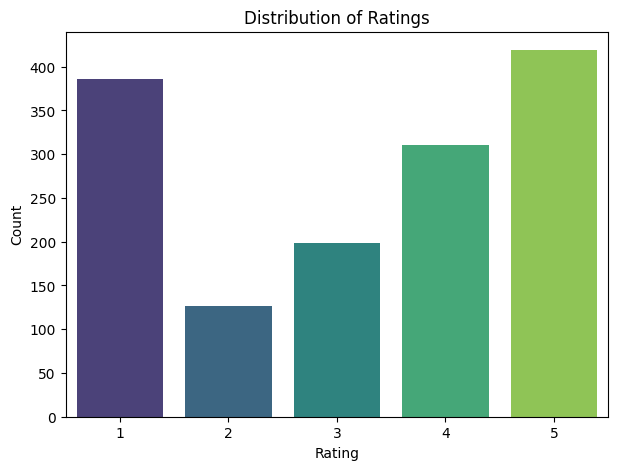

In [8]:
plt.figure(figsize=(7,5))
sns.countplot(x="rating", data=df, palette="viridis")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

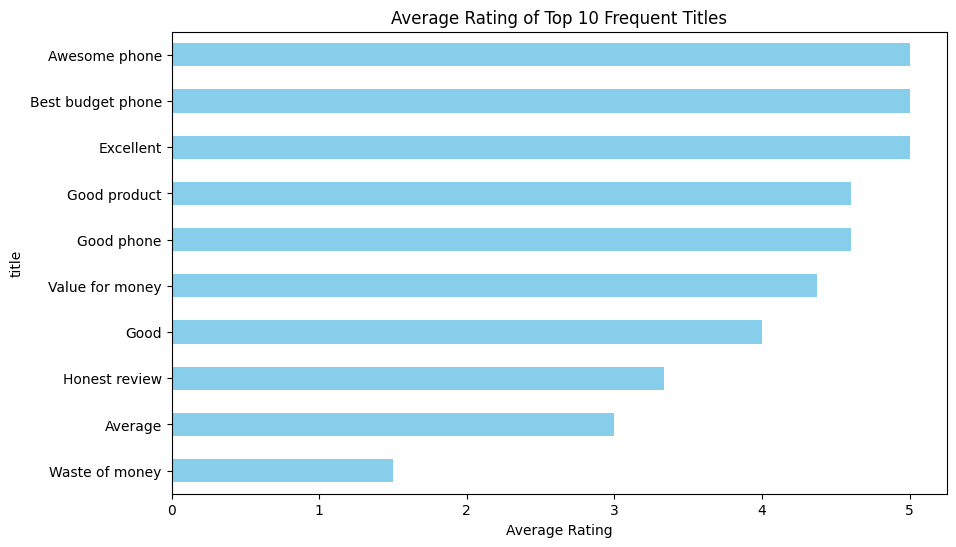

In [9]:
top_titles = df['title'].value_counts().head(10).index
avg_ratings = df[df['title'].isin(top_titles)].groupby('title')['rating'].mean().sort_values()

plt.figure(figsize=(10,6))
avg_ratings.plot(kind="barh", color="skyblue")
plt.title("Average Rating of Top 10 Frequent Titles")
plt.xlabel("Average Rating")
plt.show()

Worth buying title has the highest rating.

In [10]:
print("\n Rating count: ")
print(df['rating'].value_counts())


 Rating count: 
rating
5    419
1    386
4    310
3    199
2    126
Name: count, dtype: int64


The rating "5" has top count.

In [11]:
# Map ratings to sentiment
def map_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

df["sentiment"] = df["rating"].apply(map_sentiment)

# Count
df["sentiment"].value_counts()
df["sentiment"]

,sentiment
0,Negative
1,Neutral
2,Positive
3,Negative
4,Negative
...,...
1435,Positive
1436,Negative
1437,Positive
1438,Negative


In [13]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.4 MB/s eta 0:00:00


In [49]:
!pip install langdetect
!pip install googletrans==4.0.0-rc1
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from langdetect import detect, LangDetectException
from googletrans import Translator
import time

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)


# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
translator = Translator()

def get_wordnet_pos(treebank_tag):
    """Maps POS tag to wordnet POS tag."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def preprocess_text_with_fallback(text, retries=3, delay=1):
    """Cleans and preprocesses text with stemming fallback and translation retry."""
    if not isinstance(text, str) or not text.strip():
        return ""

    original_text = text  # Store original text for retry

    try:
        lang = detect(text)
        if lang != 'en':
            translated_text = None
            for i in range(retries):
                try:
                    translated_text = translator.translate(original_text, dest='en').text
                    break  # Success, exit retry loop
                except Exception as e:
                    print(f"Translation attempt {i+1} failed: {e}")
                    time.sleep(delay)  # Wait before retrying
            if translated_text is None:
                print(f"Failed to translate after {retries} attempts: {original_text}")
                return "" # Return empty string if translation fails after retries
            text = translated_text

    except LangDetectException:
        return ""


    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('disappointed', 'disappoint')
    text = text.replace('buying', 'buy')

    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    pos_tags = nltk.pos_tag(tokens)
    final_tokens = []
    for word, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos)
        lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos) if wordnet_pos else lemmatizer.lemmatize(word)

        if lemmatized_word == word:
            final_tokens.append(stemmer.stem(word))
        else:
            final_tokens.append(lemmatized_word)

    return " ".join(final_tokens)



# Apply preprocessing to both title and body
df['preprocessed_Title'] = df['title'].apply(preprocess_text_with_fallback)
df['preprocessed_Body'] = df['body'].apply(preprocess_text_with_fallback)

In [23]:
df[['title', 'body', 'preprocessed_Title', 'preprocessed_Body']]


,title,body,preprocessed_Title,preprocessed_Body
0,Horrible product,Very disappointed with the overall performance...,horribl product,disappoint overal perform samsung
1,Camera quality is not like 48 megapixel,Camera quality is low,camera qualiti like megapixel,camera qualiti low
2,Overall,"Got the mobile on the launch date,Battery must...",overal,get mobil launch datebatteri must appreciatedc...
3,A big no from me,1. It doesn't work with 5.0GHz WiFi frequency....,big,doesnt work ghz wifi frequenc ghz old school c...
4,Put your money somewhere else,"Not worth buying....faulty software, poor disp...",put money somewher els,worth buyfaulti softwar poor display qualiti s...
...,...,...,...,...
1435,Excellent mobile,Excellent mobile,excel mobil,excel mobil
1436,Never expected from samsung,"All over mobile performance is very poor, neve...",never expect samsung,mobil perform poor never buy one product total...
1437,Good value for money,Battery life is good but camera clarity could ...,good valu money,batteri life good camera clariti could littl g...
1438,Unreal and whitish display,"It's a very bad product, highly dissatisfied.....",unreal whitish display,bad product highli dissatisfy specif colour wh...


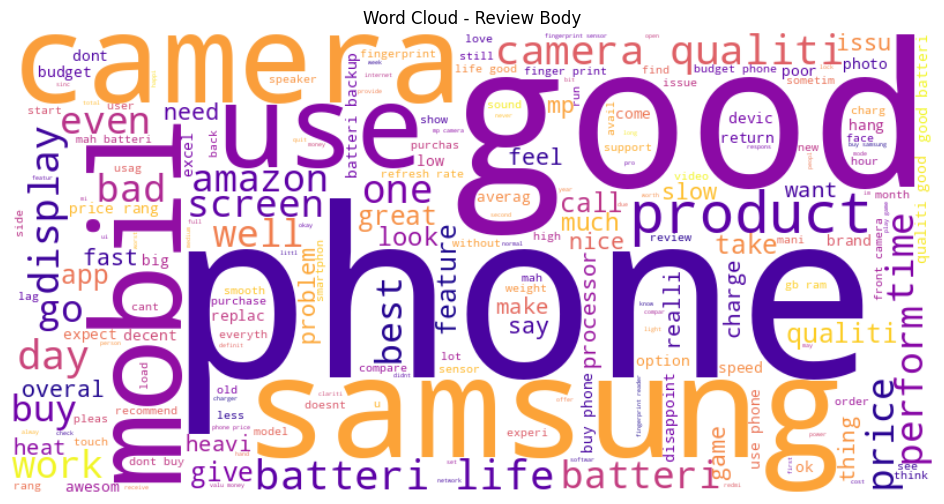

In [24]:
body_text = " ".join(df['preprocessed_Body'])

wordcloud_body = WordCloud(
    width=800, height=400,
    background_color="white",
    colormap="plasma"
).generate(body_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_body, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Review Body")
plt.show()

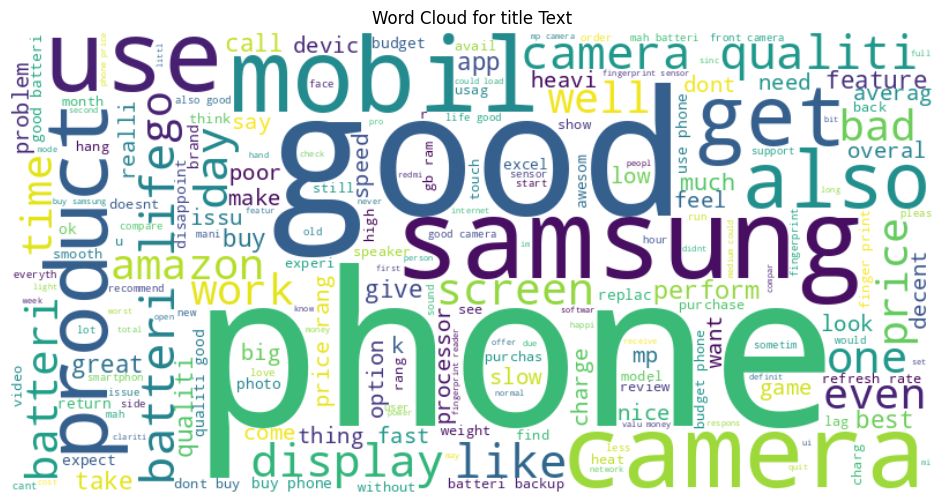

In [25]:
# Generate word cloud for preprocessed_Body
title_text = " ".join(df['preprocessed_Title'])
wordcloud_body = WordCloud(width=800, height=400, background_color="white",
                           stopwords=stop_words, colormap="viridis").generate(body_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_body, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for title Text")
plt.show()

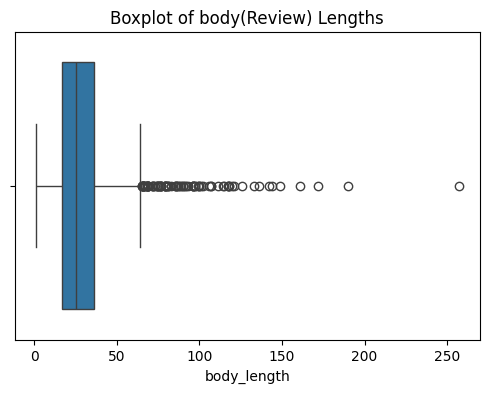

In [26]:
# Review lengths
df['body_length'] = df['preprocessed_Body'].apply(lambda x: len(str(x).split()))

# Boxplot for outlier detection
plt.figure(figsize=(6,4))
sns.boxplot(x=df['body_length'])
plt.title("Boxplot of body(Review) Lengths")
plt.show()


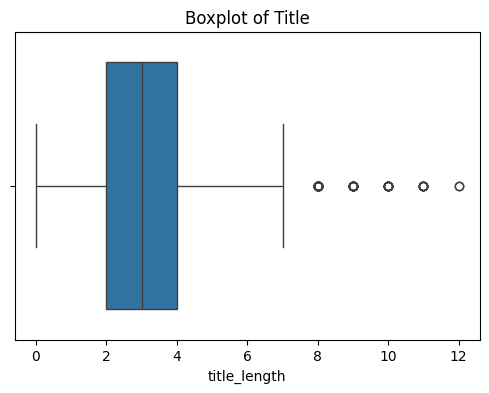

In [27]:
df['title_length'] = df['preprocessed_Title'].apply(lambda x: len(str(x).split()))

# Boxplot for outlier detection
plt.figure(figsize=(6,4))
sns.boxplot(x=df['title_length'])
plt.title("Boxplot of Title")
plt.show()

In [28]:
# Detect outliers in body_length
q1 = df['body_length'].quantile(0.25)
q3 = df['body_length'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers_body = df[(df['body_length'] < lower) | (df['body_length'] > upper)]
print("Outliers detected in body_length:", outliers_body.shape[0])


# Detect outliers in title_length
q1 = df['title_length'].quantile(0.25)
q3 = df['title_length'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers_title = df[(df['title_length'] < lower) | (df['title_length'] > upper)]
print("Outliers detected in title_length:", outliers_title.shape[0])


Outliers detected in body_length: 92
Outliers detected in title_length: 75


In [29]:
import numpy as np

# Capping outliers using IQR (winsorization)
def cap_outliers_iqr(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return np.where(series > upper_bound, upper_bound,
           np.where(series < lower_bound, lower_bound, series))


# Apply capping
df['title_length'] = cap_outliers_iqr(df['title_length'])
df['body_length'] = cap_outliers_iqr(df['body_length'])


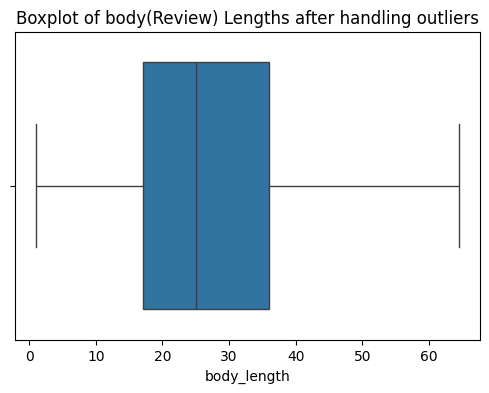

In [30]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['body_length'])
plt.title("Boxplot of body(Review) Lengths after handling outliers")
plt.show()


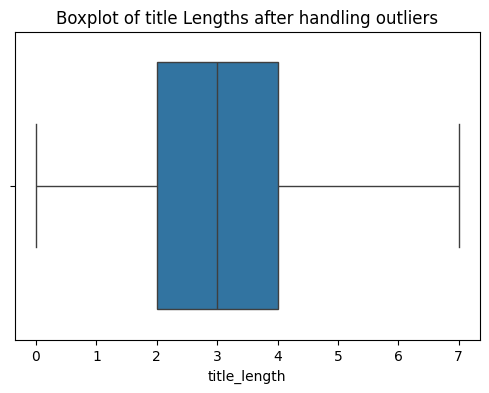

In [31]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['title_length'])
plt.title("Boxplot of title Lengths after handling outliers")
plt.show()

The outliers are handled

In [32]:
df['text'] = df['preprocessed_Body'].fillna('') + " " + df['preprocessed_Title'].fillna('')
df['text']
df['text_preprocessed'] = df['text'].apply(preprocess_text_with_fallback)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
X = df['text_preprocessed']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [34]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Logistic Regression Model Evaluation
Accuracy: 0.7743055555555556
Precision: 0.6875847017617968
Recall: 0.6049467275494673
F1-score: 0.5821371610845295
Confusion Matrix:
 [[ 85   0  17]
 [ 14   2  24]
 [  8   2 136]]


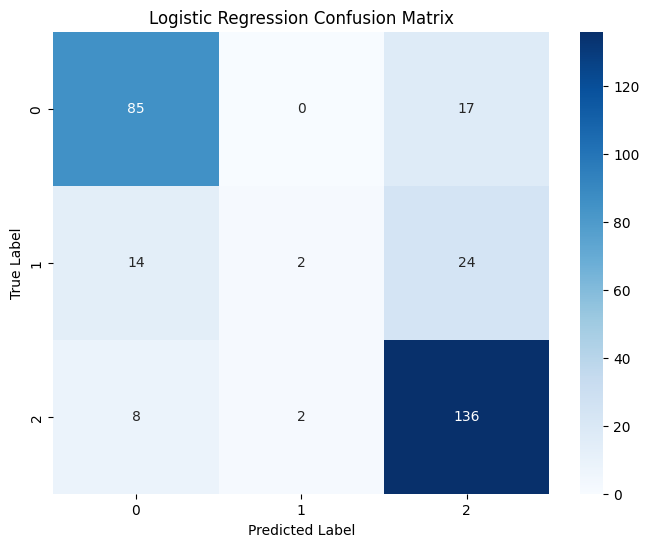

In [35]:

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print("Logistic Regression Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))
cm_lr = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## SVM Model Evaluation ##
Accuracy: 0.7777777777777778
Precision: 0.7068825942906335
Recall: 0.6273502551705613
F1-score: 0.6198459347961008
Confusion Matrix:
 [[ 87   1  14]
 [ 15   5  20]
 [ 11   3 132]]


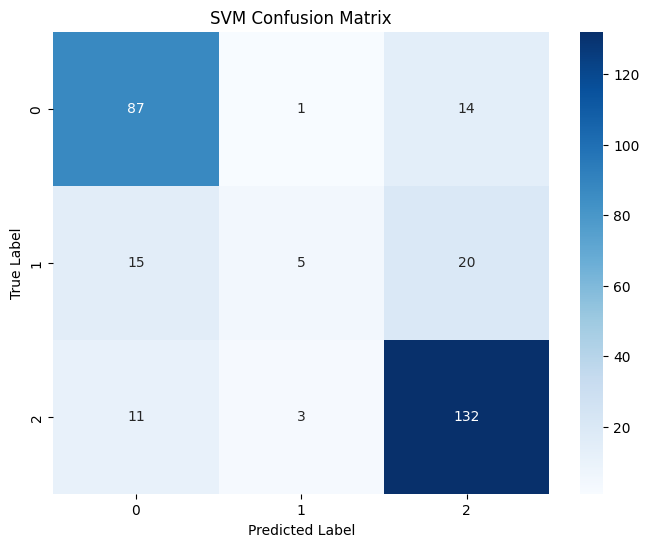

In [36]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("## SVM Model Evaluation ##")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='macro'))
print("Recall:", recall_score(y_test, y_pred_svm, average='macro'))
print("F1-score:", f1_score(y_test, y_pred_svm, average='macro'))
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", cm_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Naive Bayes Model Evaluation ##
Accuracy: 0.7361111111111112
Precision: 0.5191697191697192
Recall: 0.5509893455098934
F1-score: 0.5215147732001665
Confusion Matrix:
 [[ 68   0  34]
 [  8   0  32]
 [  2   0 144]]


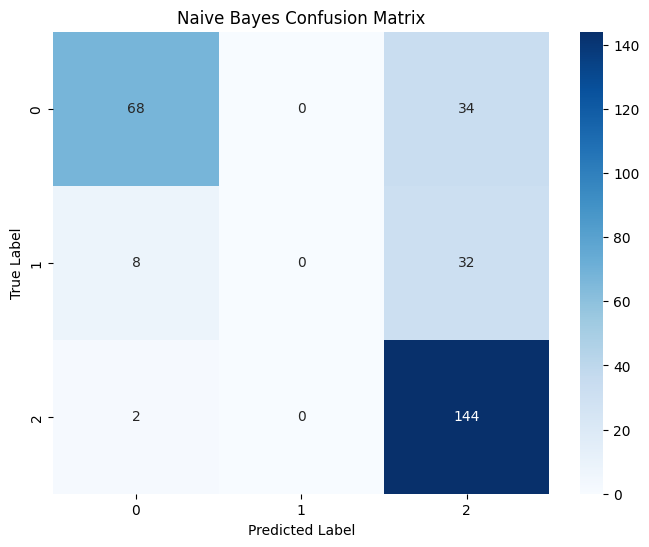

In [37]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("## Naive Bayes Model Evaluation ##")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='macro'))
print("Recall:", recall_score(y_test, y_pred_nb, average='macro'))
print("F1-score:", f1_score(y_test, y_pred_nb, average='macro'))
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix:\n", cm_nb)
plt.figure(figsize=(8,6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy: 0.7673611111111112
Precision (macro): 0.5137535420554289
Recall (macro): 0.5863103232160444
F1-score (macro): 0.5465134459036899
              precision    recall  f1-score   support

    Negative       0.78      0.81      0.80       102
     Neutral       0.00      0.00      0.00        40
    Positive       0.76      0.95      0.84       146

    accuracy                           0.77       288
   macro avg       0.51      0.59      0.55       288
weighted avg       0.66      0.77      0.71       288

Confusion Matrix:
 [[ 83   0  19]
 [ 15   0  25]
 [  8   0 138]]


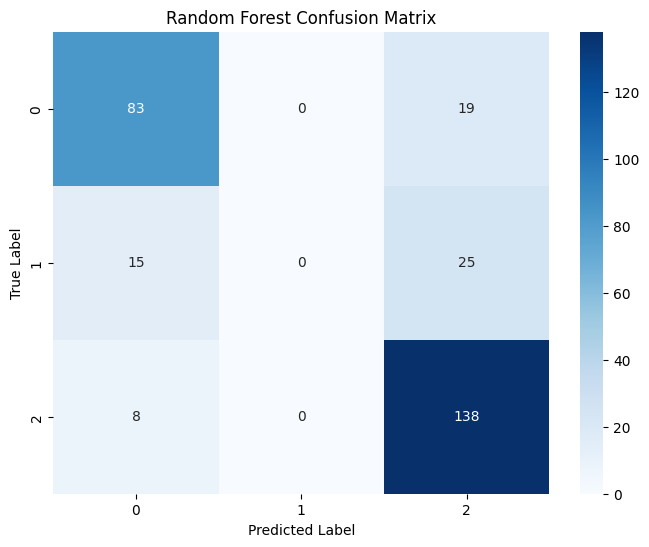

In [38]:
# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predictions and Evaluation
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision (macro):", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_rf, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_rf, average='macro'))
print(classification_report(y_test, y_pred_rf))
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm_rf)

# Heatmap of Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



--- XGBoost Model Evaluation ---

Accuracy: 0.75
Precision (macro): 0.5886824905400757
Recall (macro): 0.5910757453666398
F1-score (macro): 0.5786720423758835
              precision    recall  f1-score   support

    Negative       0.79      0.79      0.79       102
     Neutral       0.20      0.07      0.11        40
    Positive       0.77      0.90      0.83       146

    accuracy                           0.75       288
   macro avg       0.59      0.59      0.58       288
weighted avg       0.70      0.75      0.72       288

Confusion Matrix:
 [[ 81   5  16]
 [ 14   3  23]
 [  7   7 132]]


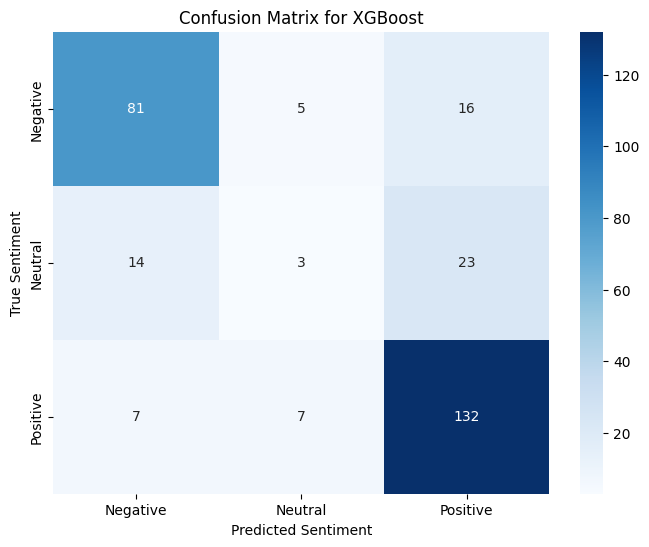

In [39]:
# --- This is the key part for handling your string labels ---
# Map sentiment labels to numerical values for XGBoost
from xgboost import XGBClassifier
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# Train and evaluate XGBoost model
model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False)
model.fit(X_train_tfidf, y_train_mapped)
y_pred_mapped = model.predict(X_test_tfidf)

# Map numerical predictions back to sentiment labels for evaluation
y_pred = pd.Series(y_pred_mapped).map({v: k for k, v in label_mapping.items()})

# Evaluation
print("\n--- XGBoost Model Evaluation ---\n")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.show()

 VADER does not need a training set to learn from.
Instead, it relies on a pre-built lexicon of words, each with a sentiment score, and a set of pre-programmed rules.
These rules are specifically designed to work with raw, unprocessed text to capture sentiment intensity.
Removing punctuation, converting text to lowercase, or eliminating other features through preprocessing would break VADER's ability to apply these rules and accurately calculate sentiment scores.
The other models you evaluated, like SVM, Logistic Regression, and XGBoost, are data-driven. This means they have no prior knowledge of sentiment and must learn it from scratch. For this learning process to happen, they require a structured pipeline.

In [40]:
 nltk.download('vader_lexicon', quiet=True)

True


--- VADER Sentiment Analyzer Evaluation ---

Accuracy: 0.7181
Precision: 0.6539
Recall: 0.7181
F1-Score: 0.6761

Classification Report:

              precision    recall  f1-score   support

    Negative       0.74      0.71      0.72       512
     Neutral       0.14      0.03      0.05       199
    Positive       0.73      0.91      0.81       729

    accuracy                           0.72      1440
   macro avg       0.54      0.55      0.53      1440
weighted avg       0.65      0.72      0.68      1440



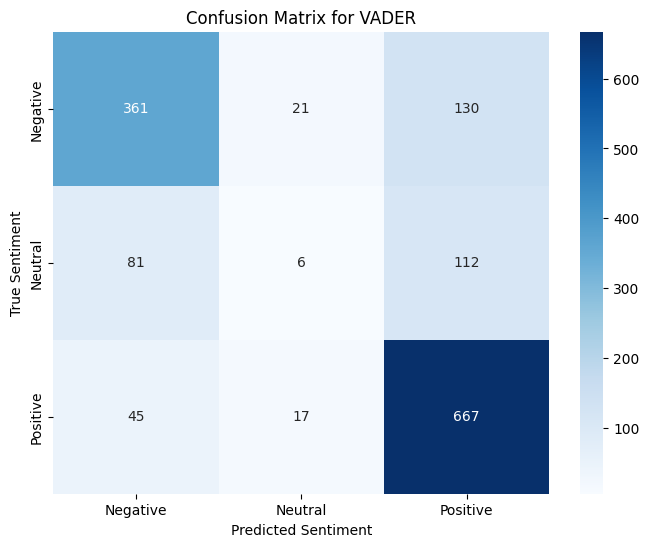

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


# Load the dataset
df = pd.read_excel('dataset.xlsx')

# Combine 'title' and 'body' for a single text feature
df['combined_text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define sentiment based on VADER's compound score
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(str(text))
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply VADER to generate sentiment predictions
df['vader_sentiment'] = df['combined_text'].apply(get_vader_sentiment)

# Categorize true sentiment from ratings (for evaluation purposes)
def categorize_true_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['true_sentiment'] = df['rating'].apply(categorize_true_sentiment)

# Evaluation
print("\n--- VADER Sentiment Analyzer Evaluation ---\n")

# Calculate and print individual metrics
accuracy = accuracy_score(df['true_sentiment'], df['vader_sentiment'])
precision = precision_score(df['true_sentiment'], df['vader_sentiment'], average='weighted')
recall = recall_score(df['true_sentiment'], df['vader_sentiment'], average='weighted')
f1 = f1_score(df['true_sentiment'], df['vader_sentiment'], average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(df['true_sentiment'], df['vader_sentiment']))

# Plot confusion matrix
cm = confusion_matrix(df['true_sentiment'], df['vader_sentiment'], labels=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix for VADER')
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.show()

In [ ]:
# SVM and Logistic Regression: Both models achieved the highest overall accuracy of 0.7743. They also had the strongest performance across the Negative and Positive classes.

# XGBoost: It also performed very well, with an accuracy of 0.75.

# Naive Bayes: While its overall accuracy was 0.736, it struggled significantly with the Neutral class, getting a recall of 0.00.

# VADER: This model had the lowest overall accuracy and F1-score, performing well on the Positive and Negative classes but failing almost completely on the Neutral class.

# Main challenge in the project: the difficulty of classifying Neutral reviews. You can show that even your best models struggle with this class, and this can be a point of discussion for future improvements

In [48]:
# app.py
import streamlit as st
import pickle
import numpy as np

# Load trained model + vectorizer
with open("sentiment_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Page setup
st.set_page_config(page_title="Sentiment Analyzer", page_icon="💬", layout="centered")
st.title("💬 Sentiment Analysis App")

user_input = st.text_area("Enter text here:")

if st.button("Analyze Sentiment"):
    if user_input.strip() == "":
        st.warning("Please enter some text!")
    else:
        # Transform input
        X = vectorizer.transform([user_input])
        prediction = model.predict(X)[0]

        # Try probability prediction
        try:
            probabilities = model.predict_proba(X)[0]
        except Exception:
            probabilities = None

        # Flexible label mapping
        classes = model.classes_  # get actual labels from model
        label_map = {
            -1: "☹️ Negative",
             0: "😐 Neutral",
             1: "😊 Positive",
             2: "😊 Positive"  # fallback if trained with 0/1/2
        }

        sentiment = label_map.get(prediction, str(prediction))
        st.subheader(f"Prediction: {sentiment}")

        # Show probability bar chart if available
        if probabilities is not None:
            st.write("### Confidence Levels")
            prob_dict = {str(classes[i]): probabilities[i] for i in range(len(classes))}
            st.bar_chart(prob_dict)


2025-09-14 14:16:23.377 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 14:16:23.389 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 14:16:23.826 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-14 14:16:23.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 14:16:23.841 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 14:16:23.846 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 14:16:23.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [42]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.4 MB/s eta 0:00:00


In [47]:
import pickle

# Save the trained Logistic Regression model
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the TF-IDF vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


In [50]:
%%writefile app.py
import streamlit as st
import pickle
import numpy as np

# Load trained model + vectorizer
with open("sentiment_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Page setup
st.set_page_config(page_title="Sentiment Analyzer", page_icon="💬", layout="centered")
st.title("💬 Sentiment Analysis App")

user_input = st.text_area("Enter text here:")

if st.button("Analyze Sentiment"):
    if user_input.strip() == "":
        st.warning("Please enter some text!")
    else:
        # Transform input
        X = vectorizer.transform([user_input])
        prediction = model.predict(X)[0]

        # Try probability prediction
        try:
            probabilities = model.predict_proba(X)[0]
        except Exception:
            probabilities = None

        # Flexible label mapping
        classes = model.classes_  # get actual labels from model
        label_map = {
            -1: "☹️ Negative",
             0: "😐 Neutral",
             1: "😊 Positive",
             2: "😊 Positive"  # fallback if trained with 0/1/2
        }

        sentiment = label_map.get(prediction, str(prediction))
        st.subheader(f"Prediction: {sentiment}")

        # Show probability bar chart if available
        if probabilities is not None:
            st.write("### Confidence Levels")
            prob_dict = {str(classes[i]): probabilities[i] for i in range(len(classes))}
            st.bar_chart(prob_dict)

Writing app.py
